# Waste Segregation
CNN based Deep Learning for Waste Segregation

## Step 1: Importing libraries and check if CUDA is available

In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

#### CUDA: Parallel Computing

CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by [`NVIDIA`](https://docs.nvidia.com/cuda/doc/index.html) that allows developers to leverage the power of NVIDIA GPUs for general-purpose computing. By using CUDA, programmers can execute complex calculations across thousands of GPU cores, significantly accelerating applications in fields like deep learning, scientific computing, and image processing.

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Step 2: Data Augmentation
Data augmentation involves techniques such as cropping, resizing, and flipping image data to achieve more accurate results. In PyTorch, this can be accomplished using transformations.

Normalization brings the data into a specific range and reduces skewness, which helps the model learn more effectively and efficiently. In PyTorch, normalization is performed using transforms.Normalize, where you provide two tuples: one for the mean values of the three RGB channels and another for their standard deviations.

Data augmentation is primarily applied to the training dataset to improve accuracy during training, which can lead to better accuracy on test data. It also increases the number of training images, allowing for multiple augmentations to be applied to training samples.

In deep learning, often the training set is split into train samples and validation samples to cross check accuracies. This is done using SubsetRandomSampler.

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

Loading the directories and training, testing data.

## Step 3: Load the Dataset   
###Waste Segregation Kaggle
/https://www.kaggle.com/datasets/dishantzaveri/wastesegregation)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dishantzaveri/wastesegregation")

print("Path to dataset files:", path)

100%|██████████| 4.04G/4.04G [00:26<00:00, 163MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dishantzaveri/wastesegregation/versions/2


In [ ]:
print(path)



/root/.cache/kagglehub/datasets/dishantzaveri/wastesegregation/versions/2


In [7]:
import os

# Check the root directory
root_dir = '/root/.cache/'
print(os.listdir(root_dir))


['uv', 'kagglehub', 'node-gyp', 'matplotlib']


In [8]:
import os

# Check the kagglehub directory
kagglehub_dir = '/root/.cache/kagglehub/'
print(os.listdir(kagglehub_dir))


['datasets']


In [9]:
# Check the datasets directory inside kagglehub
datasets_dir = kagglehub_dir + 'datasets/'
print(os.listdir(datasets_dir))


['dishantzaveri']


In [10]:
# Check the dishantzaveri directory
dishantzaveri_dir = datasets_dir + 'dishantzaveri/'
print(os.listdir(dishantzaveri_dir))


['wastesegregation']


In [11]:
# Check the wastesegregation directory
wastesegregation_dir = dishantzaveri_dir + 'wastesegregation/'
print(os.listdir(wastesegregation_dir))


['2.complete', 'versions']


In [12]:
# Check the contents of the 'versions' directory
versions_dir = wastesegregation_dir + 'versions/'
print(os.listdir(versions_dir))


['2']


In [13]:
# Check the contents of the '2' directory
version_2_dir = versions_dir + '2/'
print(os.listdir(version_2_dir))


['archive (3)', 'dataset-original', 'archive (2)']


In [14]:
# Check the contents of the 'archive (2)' directory
archive_2_dir = version_2_dir + 'archive (2)/'
print(os.listdir(archive_2_dir))


['dataset', 'DATASET']


In [15]:
# Check the contents of the 'DATASET' directory
dataset_dir = archive_2_dir + 'DATASET/'
print(os.listdir(dataset_dir))


['TRAIN', 'TEST']


In [18]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Set the paths for training and testing data
train_dir = dataset_dir + 'TRAIN/'
test_dir = dataset_dir + 'TEST/'

# Load the training and testing datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Split the training dataset into training and validation sets
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler, shuffle=False)
valid_loader = DataLoader(train_data, batch_size=32, sampler=valid_sampler, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)



### Print the number of classes and the sizes of train, valid, and test loaders:

In [19]:
# Print the number of classes
num_classes = len(train_data.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {train_data.classes}")  # Print the actual class names

# Print the size of the train, valid, and test loaders
print(f"Total training images: {len(train_loader.sampler)}")
print(f"Total validation images: {len(valid_loader.sampler)}")
print(f"Total test images: {len(test_loader.dataset)}")


Number of classes: 2
Class names: ['O', 'R']
Total training images: 18052
Total validation images: 4512
Total test images: 2513


### Define the classes for 'O' (Organic Waste) and 'R' (Recycle Waste):

In [20]:
# Map class indices to actual class names
class_names = {0: 'O', 1: 'R'}

# Print the class names
print(f"Class '0': {class_names[0]}")
print(f"Class '1': {class_names[1]}")


Class '0': O
Class '1': R


### Plot sample images from the dataset to understand the data:

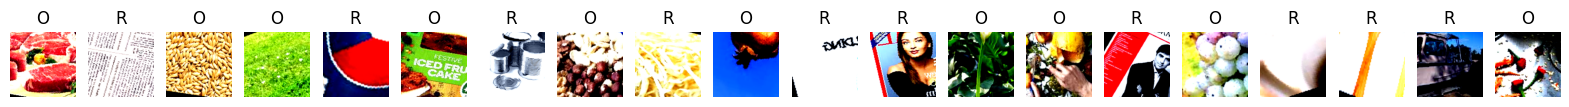

In [21]:
import matplotlib.pyplot as plt
import torch

# Function to display images from the dataloader
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images for the first 20 in the batch
fig, axes = plt.subplots(1, 20, figsize=(20, 2))
for i in range(20):
    ax = axes[i]
    img = images[i]
    label = labels[i].item()
    title = class_names[label]
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    ax.imshow(np.transpose(np_img, (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')
plt.show()


## Step 4: Data Preprocessing and Augmentation

In [22]:
from torchvision import datasets, transforms

# Data augmentation and normalization for training and testing
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


### Previewing the Augmented Data:

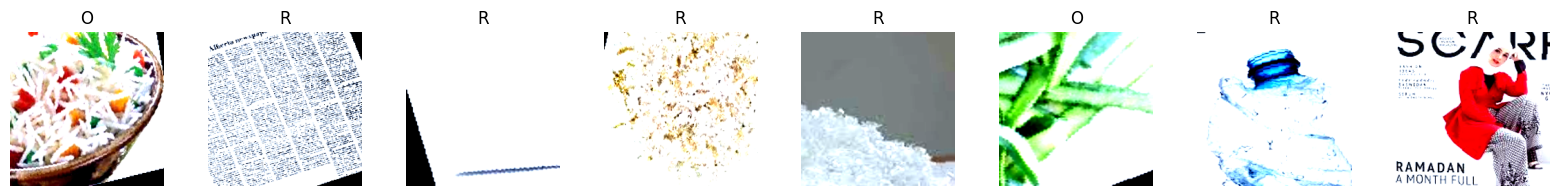

In [23]:
import matplotlib.pyplot as plt

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images for the first 8 in the batch
fig, axes = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
    ax = axes[i]
    img = images[i]
    label = labels[i].item()
    title = class_names[label]
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    ax.imshow(np.transpose(np_img, (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')
plt.show()


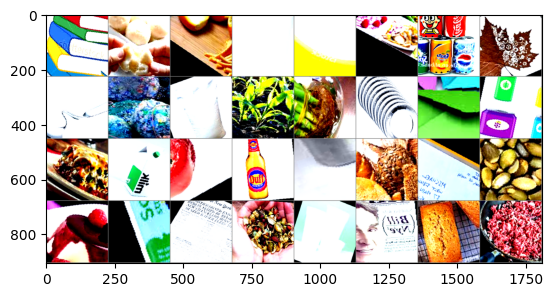

R O O R O O R O R R R O O R R R O R O R R O R O O O R O R R O O


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Define the class labels
classes = ['O', 'R']  # Define the class names (Organic, Recyclable)

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next() after iter()

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

## Step 5: Model Development

In [25]:
import torch
from torch import nn, optim

# Define CNN model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)  # Convolutional layer 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1) # Convolutional layer 2
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1) # Convolutional layer 3
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Fully connected layer 1
        self.fc2 = nn.Linear(512, 10)  # Output layer (number of classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> Pooling
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 -> Pooling
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer 1
        x = self.fc2(x)  # Output layer
        return x

# Initialize model
model = CNN_Model()
print(model)



CNN_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## Step 6: Loss Function and Optimizer





In [31]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



## Step 7: Training the Model

In [32]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send the model to the device
model.to(device)


CNN_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [33]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send the model to the device
model.to(device)

# Training and validation for 5 epochs
epochs = 5
train_losses, valid_losses = [], []

for epoch in range(epochs):
    running_train_loss = 0
    running_valid_loss = 0
    correct_valid = 0
    total_valid = 0

    # Training phase
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    # Validation phase
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    # Compute average losses
    train_loss = running_train_loss / len(train_loader.dataset)
    valid_loss = running_valid_loss / len(valid_loader.dataset)

    # Validation accuracy
    valid_accuracy = 100 * correct_valid / total_valid

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f} | Validation Accuracy: {valid_accuracy:.2f}%')


Epoch 1/5 - Training Loss: 0.4553 | Validation Loss: 0.0844 | Validation Accuracy: 81.58%
Epoch 2/5 - Training Loss: 0.4047 | Validation Loss: 0.0780 | Validation Accuracy: 82.47%
Epoch 3/5 - Training Loss: 0.3814 | Validation Loss: 0.0735 | Validation Accuracy: 83.91%
Epoch 4/5 - Training Loss: 0.3660 | Validation Loss: 0.0719 | Validation Accuracy: 84.20%
Epoch 5/5 - Training Loss: 0.3597 | Validation Loss: 0.0700 | Validation Accuracy: 84.77%


## Step 8: Testing the Model

In [34]:
# Testing the model
test_loss = 0
correct = 0
total = 0

# Initialize counters for individual classes
correct_O = 0
correct_R = 0
total_O = 0
total_R = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count correct predictions for each class
        for i in range(len(labels)):
            if labels[i] == 0:  # Assuming 'O' is class 0
                total_O += 1
                if predicted[i] == 0:
                    correct_O += 1
            elif labels[i] == 1:  # Assuming 'R' is class 1
                total_R += 1
                if predicted[i] == 1:
                    correct_R += 1

# Compute test loss and accuracy
test_loss = test_loss / len(test_loader.dataset)
overall_accuracy = 100 * correct / total
accuracy_O = 100 * correct_O / total_O if total_O > 0 else 0
accuracy_R = 100 * correct_R / total_R if total_R > 0 else 0

print(f'Test Loss: {test_loss:.4f}')
print(f'Overall Accuracy on test images: {overall_accuracy:.2f}%')
print(f'Accuracy on O (Organic) class: {accuracy_O:.2f}%')
print(f'Accuracy on R (Recyclable) class: {accuracy_R:.2f}%')


Test Loss: 0.2694
Overall Accuracy on test images: 89.49%
Accuracy on O (Organic) class: 91.22%
Accuracy on R (Recyclable) class: 87.32%


## Step 9: Data Visualization

Plotting the images to understand the data. O= Organic Waste R= Recyclable Waste

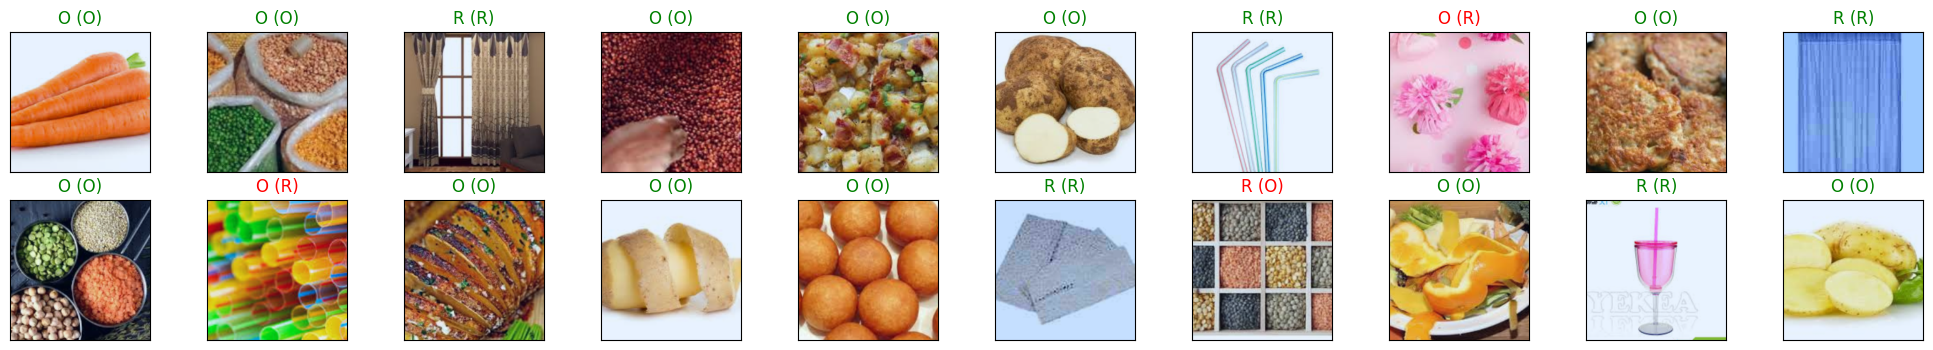

In [35]:
# obtain one batch of test images
testiter = iter(test_loader)
images, labels = next(testiter)  # Use next() to get the next batch

# move tensors to cuda, if GPU is available
if train_on_gpu:
    images = images.cuda()
    labels = labels.cuda()

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = preds_tensor.cpu().numpy()  # Ensure the predictions are on the CPU to convert to NumPy

# move images back to CPU for visualization if necessary
images = images.cpu() if train_on_gpu else images

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])
    # Convert the image tensor to numpy and scale it if needed, permute dimensions for correct visualization (H, W, C)
    img = images[idx].permute(1, 2, 0).numpy()
    # Normalize the image if it's not in [0, 1] range
    img = (img - img.min()) / (img.max() - img.min())
    # Use ax.imshow to display the image
    ax.imshow(img)

    # Set the title with predicted and true class, and color the title based on correct/incorrect prediction
    ax.set_title(
        "{} ({})".format(classes[preds[idx]], classes[labels[idx].item()]),  # Convert label tensor to scalar
        color=("green" if preds[idx] == labels[idx].item() else "red")  # Green for correct, red for incorrect
    )
plt.show()